In my [previous notebook](https://www.kaggle.com/teddykoker/training-cellular-automata-part-i-game-of-life) we explored how we could use a CNN to create a cellular automata (CA) by recurrently passing the state of the grid through itself. Now we'll solve one of the tasks [arseny-n](https://www.kaggle.com/arsenynerinovsky/cellular-automata-as-a-language-for-reasoning) solved with a hard coded CA by learning the CA instead!

In [1]:
import os
import json
import numpy as np
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import animation, rc
from IPython.display import HTML

rc('animation', html='jshtml')
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

/home/gabbo/miniconda3/envs/arc/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  /opt/conda/conda-bld/pytorch_1631630836880/work/c10/cuda/CUDAFunctions.cpp:115.)
  return torch._C._cuda_getDeviceCount() > 0


In [4]:
data_path = Path('../data/abstraction-and-reasoning-challenge')
train_path = data_path / 'training'
valid_path = data_path / 'evaluation'
test_path = data_path / 'test'

train_tasks = { task.stem: json.load(task.open()) for task in train_path.iterdir() } 
valid_tasks = { task.stem: json.load(task.open()) for task in valid_path.iterdir() } 

In [5]:
cmap = colors.ListedColormap(
        ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
         '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
norm = colors.Normalize(vmin=0, vmax=9)
    
def c(pictures, labels):
    fig, axs = plt.subplots(1, len(pictures), figsize=(2*len(pictures),32))
    for i, (pict, label) in enumerate(zip(pictures, labels)):
        axs[i].imshow(np.array(pict), cmap=cmap, norm=norm)
        axs[i].set_title(label)
    plt.show()
    
def plot_sample(sample, predict=None):
    if predict is None:
        plot_pictures([sample['input'], sample['output']], ['Input', 'Output'])
    else:
        plot_pictures([sample['input'], sample['output'], predict], ['Input', 'Output', 'Predict'])
        
def inp2img(inp):
    inp = np.array(inp)
    img = np.full((10, inp.shape[0], inp.shape[1]), 0, dtype=np.uint8)
    for i in range(10):
        img[i] = (inp==i)
    return img

def input_output_shape_is_same(task):
    return all([np.array(el['input']).shape == np.array(el['output']).shape for el in task['train']])


def calk_score(task_test, predict):
    return [int(np.equal(sample['output'], pred).all()) for sample, pred in zip(task_test, predict)]

def augment(tasks):
    # bottom up flipping
    tasks_1 = []
    for task in tasks:
        augmended_task = {}
        augmended_task['input'] = task['input'][::-1]
        augmended_task['output'] = task['output'][::-1]
        tasks_1.append(augmended_task)
        
    
    tasks_2 = []
    for task in tasks:
        augmended_task = {}
        augmended_task['input'] = task['input'][::-1]
        augmended_task['output'] = task['output'][::-1]
        for ii in range(len(augmended_task['output'])):
            augmended_task['output'][ii] = augmended_task['output'][ii][::-1]
        for ii in range(len(augmended_task['input'])):
            augmended_task['input'][ii] = augmended_task['input'][ii][::-1]
            
        tasks_2.append(augmended_task)
        
    tasks_3 = []
    for task in tasks:
        augmended_task = {}
        augmended_task['input'] = []
        augmended_task['output'] = []
        for ii in range(len(task['output'])):
            augmended_task['output'].append(task['output'][ii][::-1])
            augmended_task['input'].append(task['input'][ii][::-1])

        tasks_3.append(augmended_task)
    
    
    return tasks + tasks_1 + tasks_2 + tasks_3
    

In [6]:
tasks = train_tasks["00d62c1b"]["train"]
task = augment(tasks)
#[0,1,2,3,4,5]
#[0,1,2,3,4,5][::-1]

## First Task: db3e9e38

The task we'll first try is relitively straight foward; given a central orange "pillar", form stairs of alternating blue and orange in each direction. `arseny-n` showed that this could be solved with a CA consisting of three rules.

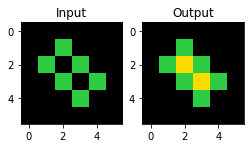

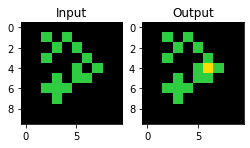

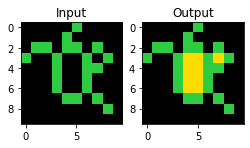

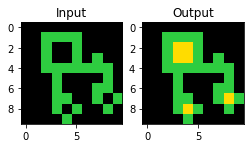

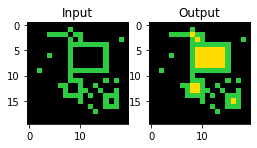

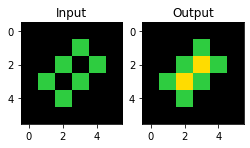

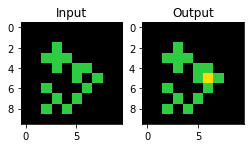

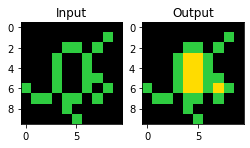

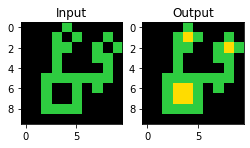

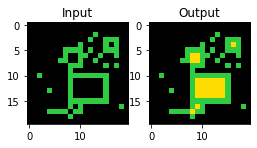

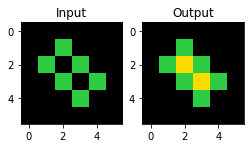

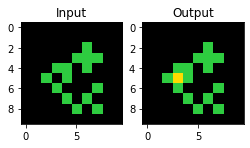

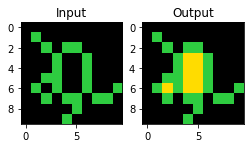

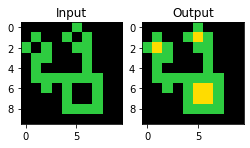

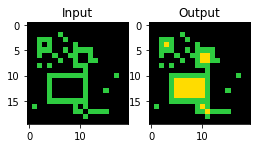

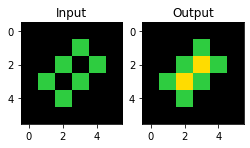

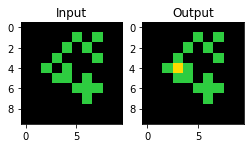

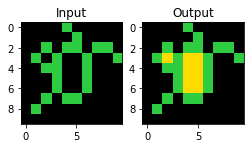

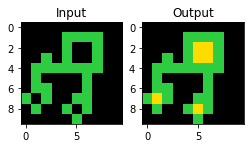

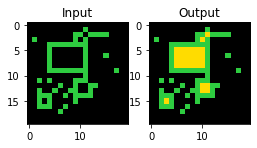

In [7]:
#task = train_tasks["00d62c1b"]["train"]
for sample in task:
    plot_sample(sample)

## The Model

The model consists of a single 3x3 convolutional layer, followed by a 1x1 convolutional layer, just like my last notebook. Here `num_states` represents how many values a single cell could have; in this case 10, one for each color. Down the road, we may want to add a hidden state, concatinating it to the input, then removing it from the output.

The foward pass of the model will repeatedly pass the grid state through the CA transition for `steps` number of times.

In [8]:
class CAModel(nn.Module):
    def __init__(self, num_states):
        super(CAModel, self).__init__()
        self.transition = nn.Sequential(
            nn.Conv2d(num_states, 128, kernel_size=5, padding=2),     
            nn.ReLU(),
            nn.Dropout(0.05),
            nn.Conv2d(128, num_states, kernel_size=1)
        )
        
    def forward(self, x, steps=1):
        for _ in range(steps):
            x = self.transition(torch.softmax(x, dim=1))
        return x
    
# class CAModel(nn.Module):
#     def __init__(self, num_states):
#         super(CAModel, self).__init__()
        
#         self.conv1 = nn.Conv2d(num_states, 128, kernel_size=5, padding=2)   
#         self.conv2 = nn.Conv2d(128, num_states, kernel_size=1)
        
#         #F.conv2d(input, weight, bias=None, stride=1, padding=2, dilation=1, 
                 
#     def forward(self, x, steps=1):
#         for _ in range(steps):

#             x = self.conv1(F.softmax(x, dim=1))
#             x = self.conv2(F.sigmoid(x))
#         return x
    

## Training

This "recurrent CNN" can be quite to difficult to train. After trying a few ideas, this seemed to be the best approach that I encountered:

* For every value $n$ = $1, ..., N$:
    1. Train the model with $n$ `steps` to produce the output from input
    2. Train the model with 1 `steps` to produce output from output
        * This enforces that the CA stabilizes after reaching a solution
        
In this way the model will try to get as close to a solution as possible in 1 step, then try to get closer in the next step, and so on until $N$ steps. For now I will use $N = 10$ = `max_steps`. I will also set the learning rate to decay with each additional step: $LR = 0.1 / (n * 2) $

In [9]:
def solve_task(task, max_steps=10):
    model = CAModel(10).to(device)
    model = model.train()
    num_epochs = 100
    criterion = nn.CrossEntropyLoss()
    losses = np.zeros((max_steps - 1) * num_epochs)

    for num_steps in range(1, max_steps):
        optimizer = torch.optim.Adam(model.parameters(), lr=(0.1 / (num_steps * 2)))
        
        for e in range(num_epochs):
            optimizer.zero_grad()
            loss = 0.0

            for sample in task:
                # predict output from input
                x = torch.from_numpy(inp2img(sample["input"])).unsqueeze(0).float().to(device)
                y = torch.tensor(sample["output"]).long().unsqueeze(0).to(device)
                y_pred = model(x, num_steps)
                loss += criterion(y_pred, y)
                
                # predit output from output
                # enforces stability after solution is reached
                y_in = torch.from_numpy(inp2img(sample["output"])).unsqueeze(0).float().to(device)
                y_pred = model(y_in, 1) 
                loss += criterion(y_pred, y)
#                 lamb = torch.tensor(0.02).float().to(device)
#                 l2_reg = torch.tensor(0.).float().to(device)
#                 for param in model.parameters():
#                     l2_reg += torch.norm(param)
#                 loss += lamb * l2_reg

            loss.backward()
            optimizer.step()
            losses[(num_steps - 1) * num_epochs + e] = loss.item()
    return model, num_steps, losses
                

In [10]:
@torch.no_grad()
def predict(model, task):
    predictions = []
    for sample in task:
        x = torch.from_numpy(inp2img(sample["input"])).unsqueeze(0).float().to(device)
        pred = model(x, 100).argmax(1).squeeze().cpu().numpy()
        predictions.append(pred)
    return predictions
    

In [ ]:
#task = train_tasks["00d62c1b"]["train"]
model, num_steps, losses = solve_task(task)

> <ipython-input-9-873b3491ab42>(27)solve_task()
     26                 import ipdb; ipdb.set_trace()
---> 27                 loss += criterion(y_pred, y)
     28 #                 lamb = torch.tensor(0.02).float().to(device)

ipdb> y_pred
tensor([[[[-0.0023, -0.0047, -0.0028,  0.0024,  0.0039,  0.0024],
          [ 0.0071,  0.0014, -0.0227, -0.0009,  0.0076,  0.0023],
          [-0.0043, -0.0067, -0.0276, -0.0180,  0.0053, -0.0055],
          [-0.0077, -0.0171, -0.0251, -0.0249, -0.0013,  0.0044],
          [ 0.0069,  0.0128, -0.0074, -0.0232,  0.0153,  0.0081],
          [ 0.0032,  0.0079,  0.0122,  0.0010,  0.0164,  0.0075]],

         [[-0.0704, -0.0647, -0.0684, -0.0686, -0.0676, -0.0574],
          [-0.0730, -0.0518, -0.0595, -0.0733, -0.0583, -0.0533],
          [-0.0496, -0.0309, -0.0610, -0.0527, -0.0283, -0.0500],
          [-0.0666, -0.0520, -0.0347, -0.0519, -0.0349, -0.0435],
          [-0.0343, -0.0450, -0.0422, -0.0361, -0.0355, -0.0501],
          [-0.0581, -0.0503, -0

$n$ is incremented every 100 epochs, so we can see that it reaches a good solution after 3 steps (epoch 300).

Now lets see if it at least correctly outputs the training set. To be save we'll give the model $n=100$ steps:

In [ ]:
predictions = predict(model.eval(), task)
for i in range(len(task)):
    plot_sample(task[i], predictions[i])

It works! Now lets see if it generalized to the test question:

In [ ]:
test = train_tasks["00d62c1b"]["test"]
predictions = predict(model.eval(), test)
for i in range(len(test)):
    plot_sample(test[i], predictions[i])

Fantastic! The coolest part now is that we can animate our solution to see the CA in action:

In [ ]:
def animate_solution(model, sample):
    x = torch.from_numpy(inp2img(sample["input"])).unsqueeze(0).float().to(device)

    @torch.no_grad()
    def animate(i):
        pred = model(x, i)
        im.set_data(pred.argmax(1).squeeze().cpu().numpy())

    fig, ax = plt.subplots()
    im = ax.imshow(x.argmax(1).squeeze().cpu().numpy(), cmap=cmap, norm=norm)
    return animation.FuncAnimation(fig, animate, frames=100, interval=120)
    
anim = animate_solution(model.eval(), train_tasks["00d62c1b"]["test"][0])
HTML(anim.to_jshtml())

We can see that the CA quickly gets to a solution and then stabilizes.

## More Tasks

Now that we know we can train a CA for one task, will it work on others?

In [ ]:
def evaluate(tasks):
    result = []
    predictions = []
    for idx, task in tqdm(tasks.items()):
        if input_output_shape_is_same(task):
            model, _, _ = solve_task(task["train"])
            pred = predict(model, task["test"])
            score = calk_score(task["test"], pred)
        else:
            pred = [el["input"] for el in task["test"]]
            score = [0] * len(task["test"])

        predictions.append(pred)
        result.append(score)
    return result, predictions

In [ ]:
train_result, train_predictions = evaluate(train_tasks)
train_solved = [any(score) for score in train_result]

total = sum([len(score) for score in train_result])
print(f"solved : {sum(train_solved)} from {total} ({sum(train_solved)/total})")

We solve many of the tasks within the training set using our Neural Cellular Automata model! I did test on the validation set as well, and it correctly solved 17 of the tasks. There are a number of ways this model could be improved. Please let me know if you'd be interested in collaboration!

## Solved Tasks

In [ ]:
for task, prediction, solved in tqdm(zip(train_tasks.values(), train_predictions, train_solved)):
    #if solved:
    for i in range(len(task['train'])):
        plot_sample(task['train'][i])
            
    for i in range(len(task['test'])):
        plot_sample(task['test'][i], prediction[i])

That's all for now, thanks for reading!